The objective of the project is to implement language translation model aka machine translation for converting German to English(and vice versa)

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth',200)

Our data is a text file of English-German sentence pairs.First we will read the file using the function defined below.

In [ ]:
#function to read raw text file
def read_text(filename):
  #open the file
  file= open(filename, mode='rt', encoding= 'utf-8')
  #read all text
  text= file.read()
  file.close()
  return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [ ]:
#split a text into sentences
def to_lines(text):
  sents= text.strip().split('\n')
  sents= [i.split('\t') for i in sents]
  return sents

In [ ]:
data= read_text("/content/sample_data/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The actual data contains over 1,50,000 sentence pairs.However, we will use the first 50,000 sentence pairs only to reduce the training time of the model.



In [ ]:
deu_eng = deu_eng[:50000,:]

In [ ]:
#Let's take a look at our data
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['We took a wrong turn.', 'Wir sind falsch abgebogen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['We traveled together.', 'Wir waren zusammen auf Reisen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['We traveled together.', 'Wir sind zusammen gereist.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

Text to sequence conversion: To find our data in a Seq2Seq model, we will have to convert both the input and output sentences into integer sequences of fixed length.Before that,let's visualise the length of the sentences.We will capture the length of all the sentences in 2 seperate lists for English and German respectively.



In [ ]:
#empty lists
eng_l =[]
deu_l =[]

#populate the lists with sentence lengths
for i in deu_eng[:,0]:
  eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
  deu_l.append(len(i.split()))

In [ ]:
length_df = pd.DataFrame({'eng': eng_l, 'deu': deu_l})

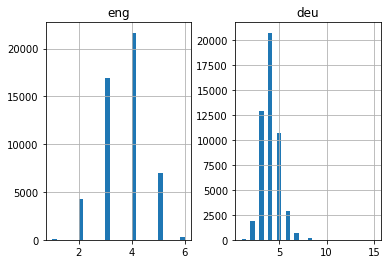

In [ ]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8. Let's vectorize on text data by using Keras's Tokenizer() class.It will turn our sentences into sequences of integers.Then we will pad those sequences with zerosto make all the sequences of same length.

In [ ]:
#function to build a tokenizer
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
#prepare English tokenizer
eng_tokenizer = tokenization(deu_eng[:,0])
eng_vocab_size = len(eng_tokenizer.word_index)+1

eng_length = 8
print('English Vocabulary Size: %d' %eng_vocab_size)

English Vocabulary Size: 6150


In [ ]:
#prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:,1])
deu_vocab_size= len(deu_tokenizer.word_index) +1

deu_length = 8
print('Deutch Vocabulary Size = %d' % deu_vocab_size)

Deutch Vocabulary Size = 10119


Given below is a function to prepare the sequences.It will also perform sequence padding to a maximum sentence length as mentioned above.


In [ ]:
#encode and pad sequences
def encode_sequences(tokenizer,length,lines):
  #integer encode sequences
  seq = tokenizer.texts_to_sequences(lines)
  #pad sequences with 0 values
  seq = pad_sequences(seq, maxlen= length, padding = 'post')
  return seq

Model building.

We will now split the data into train and test set for modeltraining and evaluation respectively.

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences.We will encode German sentences as the input sequences and English sentences as the target sequences.It will be done for both train and test data sets.


In [ ]:
#prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:,1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:,0])

In [ ]:
#prepare validation data
testX = encode_sequences(deu_tokenizer,deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:,0])

Now cover the exciting part!Let us define our Seq2Seq model architecture.We are using Embedded layer & an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.



In [ ]:
#Build NMT Model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
     model= Sequential()
     model.add(Embedding(in_vocab, units, input_length= in_timesteps, mask_zero= True))
     model.add(LSTM(units))
     model.add(RepeatVector(out_timesteps))
     model.add(LSTM(units, return_sequences= True))
     model.add(Dense(out_vocab, activation='softmax'))
     return model
     

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [ ]:
model= build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr = 0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


We have used 'sparse_categorical_crossentropy' as the loss function because it allows us to use the target sequence as it is instead of 1 hot encoded format.One hot encoding the target sequences with such a large vocabulary might consume our systems's entire memory. It seems we are all set to start training our model.We will train it for 30 epochs & with a batch size of 512.You may change & play these hyperparameters.We will also be using Modelchekpoint() to save the best model with lowest validation loss.I personally prefer this method over early stopping.


In [ ]:
filename = 'model.h1.24_rajalaxmi'
checkpoint = ModelCheckpoint(filename, monitor= 'val_loss', verbose=1, save_best_only = True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0],trainY.shape[1], 1),
          epochs = 5, batch_size=512,
          validation_split = 0.2,
          callbacks = [checkpoint], verbose=1)

Epoch 1/5
63/63 [==============================] - 203s 3s/step - loss: 4.2809 - val_loss: 2.8457

Epoch 00001: val_loss improved from inf to 2.84570, saving model to model.h1.24_rajalaxmi


INFO:tensorflow:Assets written to: model.h1.24_rajalaxmi/assets


INFO:tensorflow:Assets written to: model.h1.24_rajalaxmi/assets


Epoch 2/5
63/63 [==============================] - 180s 3s/step - loss: 2.7259 - val_loss: 2.6494

Epoch 00002: val_loss improved from 2.84570 to 2.64939, saving model to model.h1.24_rajalaxmi


INFO:tensorflow:Assets written to: model.h1.24_rajalaxmi/assets


INFO:tensorflow:Assets written to: model.h1.24_rajalaxmi/assets


Epoch 3/5
63/63 [==============================] - 181s 3s/step - loss: 2.5523 - val_loss: 2.4717

Epoch 00003: val_loss improved from 2.64939 to 2.47168, saving model to model.h1.24_rajalaxmi


INFO:tensorflow:Assets written to: model.h1.24_rajalaxmi/assets


INFO:tensorflow:Assets written to: model.h1.24_rajalaxmi/assets


Epoch 4/5
63/63 [==============================] - 179s 3s/step - loss: 2.3692 - val_loss: 2.3490

Epoch 00004: val_loss improved from 2.47168 to 2.34905, saving model to model.h1.24_rajalaxmi


INFO:tensorflow:Assets written to: model.h1.24_rajalaxmi/assets


INFO:tensorflow:Assets written to: model.h1.24_rajalaxmi/assets


Epoch 5/5
63/63 [==============================] - 179s 3s/step - loss: 2.2101 - val_loss: 2.2319

Epoch 00005: val_loss improved from 2.34905 to 2.23191, saving model to model.h1.24_rajalaxmi


INFO:tensorflow:Assets written to: model.h1.24_rajalaxmi/assets


INFO:tensorflow:Assets written to: model.h1.24_rajalaxmi/assets


Let's compare the training loss & validation loss

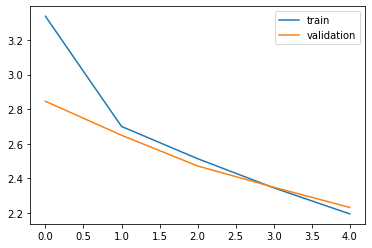

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

Let's load the saved model to make predictions.

In [ ]:
model = load_model('model.h1.24_rajalaxmi')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
  return None

In [ ]:
#convert prediction into text(English)
preds_text =[]
for i in preds:
  temp =[]
  for j in range(len(i)):
      t = get_word(i[j], eng_tokenizer)
      if j> 0:
         if(t== get_word(i[j-1], eng_tokenizer))or(t== None):
            temp.append('')
         else:
             temp.append(t)

      else:
         if(t== None):
             temp.append('')
         else:
             temp.append(t)
  preds_text.append(''.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual': test[:,0], 'predicted': preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

,actual,predicted
0,What is the number?,the
1,Try it on.,pleaseare
2,We were wrong.,we'renot
3,That's untrue.,itis
4,Don't touch anything.,you'reare
5,Tom is calling back.,tomisvery
6,I think Tom is awake.,iwastom
7,What are you having?,howdoyou
8,I like that flag.,ihavea
9,You have a good job.,didyoua


In [ ]:
pred_df.tail(15)

,actual,predicted
9985,I saw you looking.,ihavetoma
9986,Tom was so busy.,tomisa
9987,Where could he be?,hedidyou
9988,My friend was shot.,myis
9989,"Come on, trust me.",whatyou
9990,Life is too short.,heisa
9991,Everybody saw it.,areyoutom
9992,Try harder.,pleaseme
9993,He will be punished.,heisa
9994,I speak Swedish.,iam
